# HFVQEの実装

In [1]:
from qulacs import *
from qulacs.gate import *
from qulacs.state import *
from scipy import stats
from collections import Counter
import numpy as np

## 標的の情報

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from openfermion.chem import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermionpyscf import run_pyscf
from pyscf import fci

In [4]:
## basis,multiplicity,charge,geometry(原子種と原子の位置),descriptionを定義する．
basis = "sto-3g"
multiplicity = 1
charge = 0
distance  = 0.74
geometry = [["H", [0,0,0]],["H", [0,0,distance]]]
description  = "tmp"

In [5]:
## OpenFermionのmolecular-dataを読み取る
molecule = MolecularData(geometry, basis, multiplicity, charge, description) #openfermionのMolecularDataをもとに
molecule = run_pyscf(molecule,run_scf=1,run_fci=1)

## ハミルトニアンを生成する．
fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)

## ハミルトニアンをQulacsに使える形に直す
from qulacs import Observable
from qulacs.observable import *
qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))

nqubit,nelectron = molecule.n_qubits,molecule.n_electrons

## HF,FCIによる基底エネルギー

In [6]:
### Hartree Fock State
def HF_state(nqubit,nelectron):
    state = QuantumState(nqubit)
    circuit = QuantumCircuit(nqubit)
    for i in range(nelectron):
        circuit.add_gate(X(i))
    circuit.update_quantum_state(state)
    return state

hf_energy = qulacs_hamiltonian.get_expectation_value(HF_state(nqubit,nelectron))
print("HF Energy: {} eV".format(hf_energy))

### FCI
exact_energy = molecule.fci_energy
print("Exact Energy: {} eV".format(exact_energy))

HF Energy: -1.1167593073964248 eV
Exact Energy: -1.137283834488502 eV


## HFVQEの実装

In [7]:
import numpy as np
def Gate(gate,n):
    """
    change type of gate
    """
    return merge(gate,Identity(n))

def ctrl_gate(U,c):
    """
    control gate
    """
    return add(P0(c),merge(P1(c),U))

def U1ex(theta,phi,m,n):
    """
    exchange gate defined by PHYSICAL REVIEW A 98, 022322 (2018)
    """
    u_a = Gate(X(n),n)
    u_a.multiply_scalar(np.exp(-1j*phi))
    u_b1 = Gate(Z(m),m)
    u_b1.multiply_scalar(np.cos(theta))
    u_b2 = Gate(X(m),m)
    u_b2.multiply_scalar(np.sin(theta))
    u_b = add (u_b1,u_b2)
    u_c = Gate(X(n),n)
    u_c.multiply_scalar(np.exp(1j*phi))
    ex_gate = merge(merge(ctrl_gate(u_a,m),ctrl_gate(u_b,n)),ctrl_gate(u_c,m))
    return ex_gate

def U2ex(theta,m,n):
    """
    exchange gate defined by PHYSICAL REVIEW A 98, 022322 (2018)
    """
    u_a = Gate(X(n),n)
    u_a.multiply_scalar(1)
    u_b1 = Gate(Identity(m),m)
    u_b1.multiply_scalar(np.cos(2*theta))
    u_b2 = Gate(X(m),m)
    u_b2.multiply_scalar(np.sin(2*theta)*-1j)
    u_b = add (u_b1,u_b2)
    u_c = Gate(X(n),n)
    u_c.multiply_scalar(1)
    ex_gate = merge(merge(ctrl_gate(u_a,m),ctrl_gate(u_b,n)),ctrl_gate(u_c,m))
    return ex_gate

#print(U1ex(0.3,0.2,0,1))
#print(U2ex(0.3,0,1))

In [8]:
from scipy.optimize import minimize
depth = nqubit
S=0.9997

### Layerの実装 U1exを用いたものを使ってみる
def circuit_entangler(depth,nqubit,theta_list):
    """
    entangelers defined using exchange gates.
    (Ref: PHYSICAL REVIEW A 98, 022322 (2018))
    """
    circuit = QuantumCircuit(nqubit)
    for d in range(depth):
        for n in range(1,nqubit):
            circuit.add_gate(ctrl_gate(U1ex(theta_list[d*nqubit+2*n],theta_list[d*nqubit+2*n+1],n-1,n),0))
    return circuit

### 最適化
def cost(theta_list):
    """
    cost function for CBVQE. (To be discussed.)
    """
    ## <ψq|H|ψq>の計算
    Qstate = HF_state(nqubit,nelectron) #|00000> を準備
    circuit = circuit_entangler(depth,nqubit,theta_list) #量子回路を構成
    circuit.update_quantum_state(Qstate) #量子回路を状態に作用
    E_qq = qulacs_hamiltonian.get_expectation_value(Qstate)
    ## <ψq|H|ψcl>の計算
    E_qcl = qulacs_hamiltonian.get_transition_amplitude(HF_state(nqubit,nelectron), Qstate)
    return  ((1-S**2)*E_qq + 2*S*(1-S**2)**0.5*E_qcl + S**2*hf_energy).real #ハミルトニアンの期待値を計算

cost_history = []
theta_list = np.random.rand(2*depth*(nqubit-1))
cost_history.append(cost(theta_list))

#print(cost(theta_list),theta_list,hf_state)
method = "BFGS"
options = {"disp": True, "maxiter": 50, "gtol": 1e-6}
opt = minimize(cost, theta_list,
               method=method,
               callback=lambda x: cost_history.append(cost(x)))

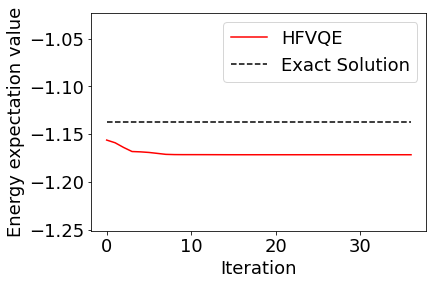

End. If no number above, then you might not reach to precision wanted.


In [9]:
plt.rcParams["font.size"] = 18
plt.plot(cost_history, color="red", label="HFVQE")
plt.plot(range(len(cost_history)), [exact_energy]*len(cost_history), linestyle="dashed", color="black", label="Exact Solution")
plt.xlabel("Iteration")
plt.ylabel("Energy expectation value")
plt.ylim([exact_energy*1.1,exact_energy*0.9])
plt.legend()
plt.show()

presision=0.0001

for i in range(len(cost_history)):
    if abs(cost_history[i]-exact_energy)<presision:
        print(i+1)
        break
print("End. If no number above, then you might not reach to precision wanted.")

## 参考文献
arXiv:2106.04755v1 <br>
Quantum Native Dojo VQE. chap6-2 <br>
PHYSICAL REVIEW A 98, 022322 (2018)

## 疑問点
1.
\begin{eqnarray}
    \left|\psi_G\right> = S\left|\psi_{cl}\right> + \sqrt{1-S^2}\left|\psi_{q}\right>
\end{eqnarray}
でSをどのようにして定義するかが分からかった．そのため，コスト関数の定義以降の議論は誤っている可能性がある．

2.
また，測定回数というのがアダマールテストの測定回数なのか，Iterationの回数なのかが論文に明示されていないように思った．

3.
Qubitの数をどのようにして指定するかが(基底を変更する以外の方法で)分からなかった．